<!-- Notebook Header Start -->

<h1 align="center">Spike Sorting</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2024-11-18<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---

## 📜 Project Overview

(to populate) 

- **Objective:** (to populate)
- **Scope:** (to populate)

---

## 📊 Notebook Outline

1. **Data Import & Preprocessing**


---

## 📚 References & Additional Resources

- [Kilosort4](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# Importing Libraries & Data
---

### imports

In [1]:
# standard imports
from pathlib import Path
import os
import pandas as pd
import numpy as np
from kilosort import io

# custom imports
from automations import RM1
from automations import kilosort_wrapper

### filepath definitions

In [2]:
# Parameters
RAT_ID = 'DW322'
STIMULATION = 'DRGS_2_240918_130024'
SAVE_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
DATA_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# Create path if it doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)
PROBE_DIRECTORY = Path(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.001 Kilosort on DW322\A1x32-Edge-5mm-20-177-A32.prb')

### probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

In [3]:
channel_mapping = pd.read_excel("Adapter_pinout.xlsx",sheet_name="summary",header=2).iloc[:,[8,10,12,14]]
channel_mapping.head(5)

,A1x32 Probe.1,A32->O32 Adapter.1,Intan Board,Intan Input.1
0,32,32,T13,19
1,31,30,T14,20
2,30,31,B13,28
3,29,28,T15,21
4,28,29,B14,27


In [4]:
DW322 = RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, RAT_ID)

Reading DRGS_10_240918_140034...
Reading DRGS_11_240918_140803...
Reading DRGS_12_240918_141655...
Reading DRGS_1_240918_125448...
Reading DRGS_2_240918_130024...
Reading DRGS_3_240918_130835...
Reading DRGS_4_240918_131552...
Reading DRGS_5_240918_132233...
Reading DRGS_6_240918_132920...
Reading DRGS_7_240918_133719...
Reading DRGS_8_240918_134529...
Reading DRGS_9_240918_135255...
Reading ST_10_240918_121843...
Reading ST_11_240918_121936...
Reading ST_12_240918_122008...
Reading ST_13_240918_122039...
Reading ST_14_240918_122108...
Reading ST_15_240918_122138...
Reading ST_16_240918_122212...
Reading ST_17_240918_122340...
Reading ST_18_240918_122422...
Reading ST_19_240918_122503...
Reading ST_1_240918_120552...
Reading ST_1_240918_120737...
Reading ST_20_240918_122539...
Reading ST_21_240918_122639...
Reading ST_22_240918_122715...
Reading ST_23_240918_122749...
Reading ST_24_240918_122818...
Reading ST_25_240918_122857...
Reading ST_2_240918_120808...
Reading ST_3_240918_121059.

### I now have all raw data for Rat DW322 imported and structured into a class

#### example usage:

In [5]:
# for example, pulling the amp data from the 7th DRGS trial
DW322.mat_files_dict["DRGS_7_133719"]["AM"]["amp"][0, 0][0, 0]

51

In [6]:
DW322.qst_experiment_notes

'd1 tl, d2 am sync, a1 am monitor,a2 evf'

In [7]:
DW322.drgs_trial_notes

5,Trial Number,Condition,amp (uA),PW (us),Freq. (Hz),Dur. (s),Stimuli,Stage,Stimuli Dur.,rcrtrange,waitime,NaN
Trial Number,,,,,,,,,,,,
1,1,DRGS,51,300,5,180,NaN,NaN,NaN,"49,57",30,spont act in some nn channels?
2,2,DRGS,51,300,5,180,NaN,NaN,NaN,"49,57",30,spont act in some nn channels?
3,3,DRGS,51,300,100,180,NaN,NaN,NaN,"49,57",30,NaN
4,4,DRGS,51,300,20,180,NaN,NaN,NaN,"49,57",30,NaN
5,5,DRGS,51,300,20,180,NaN,NaN,NaN,"49,57",30,NaN
6,6,DRGS,51,300,100,180,NaN,NaN,NaN,"49,57",30,NaN
7,7,DRGS,51,300,5,180,NaN,NaN,NaN,"49,57",60,NaN
8,8,DRGS,51,300,100,180,NaN,NaN,NaN,"49,57",60,NaN
9,9,DRGS,51,300,5,180,NaN,NaN,NaN,"49,57",60,NaN


# Preprocessing Data

### first I must process it for import into Kilosort

I will use a combination of `SpikeInterface` & `Kilosort.io.extractors` to get the data I need

In [8]:
analysis = kilosort_wrapper(DW322, SAVE_DIRECTORY)

DW322


In [9]:
analysis.save_spinalcord_data_to_binary(TRIAL_NAMES=["DRGS_2_240918_130024","DRGS_9_240918_135255"])

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\DRGS_2_240918_130024\DW322_DRGS_2_240918_130024_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: -------------------------------------

Running kilosort on D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\DRGS_2_240918_130024


kilosort.run_kilosort: N samples: 7750400
kilosort.run_kilosort: N seconds: 258.3466666666667
kilosort.run_kilosort: N batches: 130
kilosort.run_kilosort: Preprocessing filters computed in  0.40s; total  0.40s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    20.20 %
kilosort.run_kilosort: Memory:       65.81 %     |     31.54   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   14.22 %     |      1.14   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     1.47 %     |      0.12   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilo

Running kilosort on D:\Data\CMU.80 Data\88 Analyzed Data\88.002 Multi rat kilosort export\binary\DRGS_9_240918_135255


kilosort.spikedetect: Number of universal templates: 63
kilosort.spikedetect: Detecting spikes...
100%|██████████| 146/146 [00:10<00:00, 14.19it/s]
kilosort.run_kilosort: drift computed in  10.92s; total  11.04s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    35.00 %
kilosort.run_kilosort: Memory:       67.30 %     |     32.26   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   15.98 %     |      1.28   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     2.13 %     |      0.17   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run

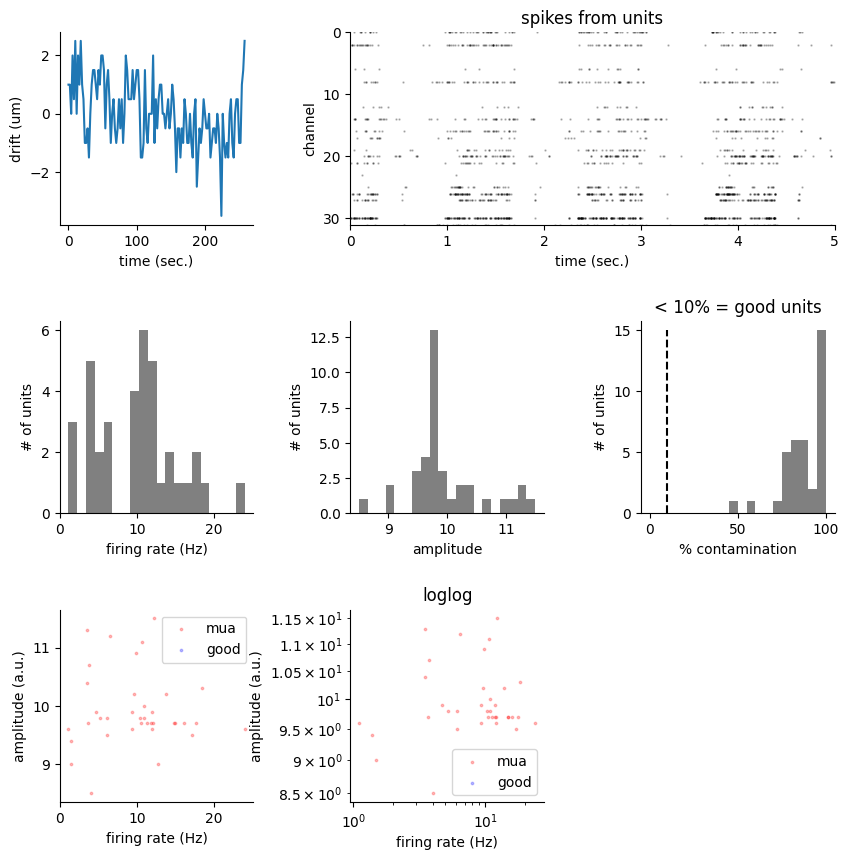

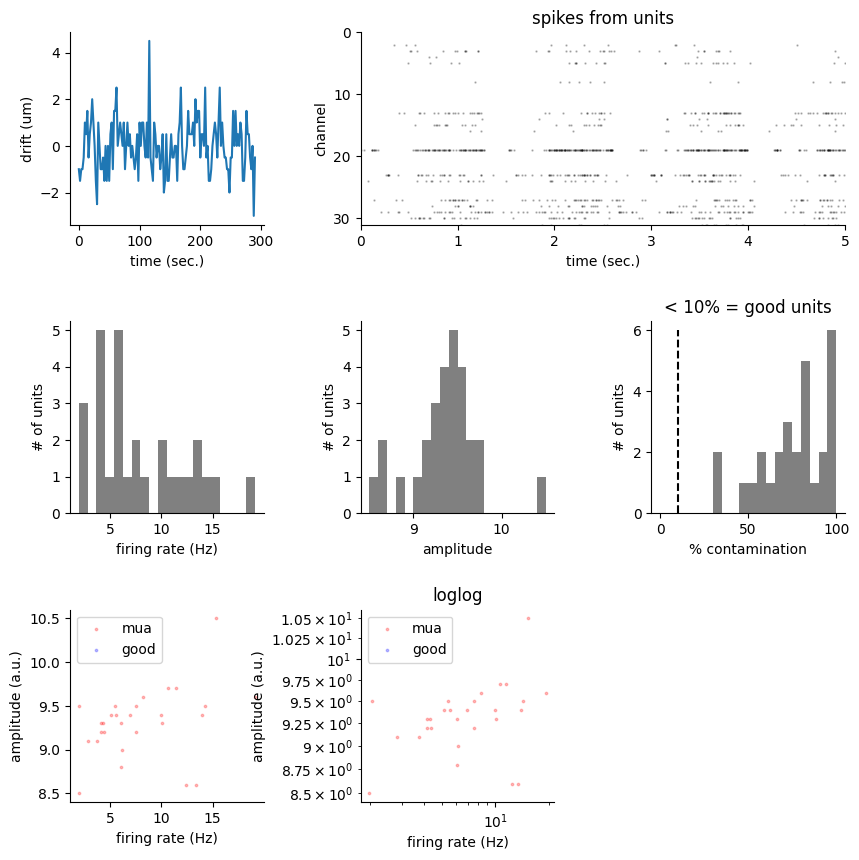

In [10]:
analysis.run_spinalcord_kilosort()